In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv("../data/Phoneme Recognition.txt")
df = df[(df.g == 'aa')|(df.g == 'ao')]
df.g = pd.get_dummies(df.g)['aa']
names = [f'x.{i+1}' for i in range(256)]

In [3]:
X, y = df[names].values, df[['g']].values

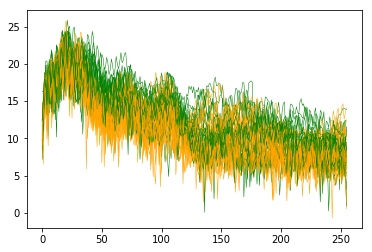

In [4]:
for i in range(50):
    plt.plot(range(256), X[i], linewidth=0.5, color=('orange', 'green')[y[i,0]])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, random_state=7)

/home/andrey/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [45]:
ls = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)
r = ls.predict(sm.add_constant(X_train)) - np.squeeze(y_train)
print('Training error', r @ r / X_train.shape[0])
r = ls.predict(sm.add_constant(X_test)) - np.squeeze(y_test)
print('Test error', r @ r / X_train.shape[0])

Training error 0.05781428260343094
Test error 0.1514664741332207


/home/andrey/tensorflow/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/andrey/tensorflow/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


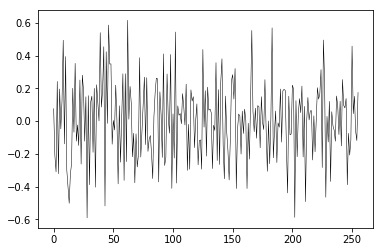

In [31]:
plt.plot(range(256), ls.params[1:], linewidth=0.5, color='black')